In [197]:
import pandas as pd
from category_encoders import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import mysql.connector
import seaborn as sns


In [95]:
mydb=mysql.connector.connect(user='user_5', password= 'Bonfire124', host='localhost', database= 'week_5_project')
cur= mydb.cursor()
"""
This query statement pulls only non-event game modes and the game type of tournament. This is to let the model see only actual game play that matters.
Do to the structure of the original data randomly inserting the heroes played in each match, the order of draft is completely lost.
Do to this, the model is to assume the order of heroes won't matter. So all game_modes are plugged in.
One thing to note, is that after tidying the data, it comes out to 102,944 entries. This sql query will then only pull 51,661 entries.
This means the model will be based on only 50.18% of the original data.
"""
cur.execute("""SELECT * FROM dota_2_matches 
            WHERE game_type <> 'tutorial' 
            AND game_type <> 'practice'
            AND game_mode <> 'greeviling'
            AND game_mode <> 'intro_death'
            AND game_mode <> 'the_diretide';""")
column_names = ['winning_team',
    'cluster_id' ,
    'game_mode',
    'game_type',
    'radiant_player_1',
    'radiant_player_2',
    'radiant_player_3',
    'radiant_player_4',
    'radiant_player_5',
    'dire_player_1',
    'dire_player_2',
    'dire_player_3',
    'dire_player_4',
    'dire_player_5']
df = pd.DataFrame.from_dict(cur.fetchall())
df.drop(0,axis=1,inplace=True)

df.columns = column_names
# df.drop("game_mode", axis=1, inplace=True)
df.drop("game_type", axis=1, inplace=True)
# df.drop("cluster_id", axis=1, inplace=True)
df


,winning_team,cluster_id,game_mode,radiant_player_1,radiant_player_2,radiant_player_3,radiant_player_4,radiant_player_5,dire_player_1,dire_player_2,dire_player_3,dire_player_4,dire_player_5
0,dire,china,captains_mode,morphling,pudge,lina,slardar,riki,sven,zeus,beastmaster,invoker,nyx_assassin
1,radiant,southeast_asia,captains_mode,bloodseeker,pudge,lion,shadow_shaman,spirit_breaker,drow_ranger,windranger,sniper,slark,timbersaw
2,radiant,europe_west,captains_mode,bloodseeker,zeus,lina,riki,huskar,drow_ranger,vengeful_spirit,templar_assassin,gyrocopter,slark
3,radiant,southeast_asia,captains_mode,storm_spirit,sniper,lifestealer,bounty_hunter,troll_warlord,earthshaker,kunkka,wraith_king,viper,legion_commander
4,dire,southeast_asia,captains_mode,bloodseeker,witch_doctor,templar_assassin,huskar,ember_spirit,juggernaut,riki,phantom_assassin,ogre_magi,disruptor
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51656,dire,southeast_asia,captains_mode,tiny,ancient_apparition,troll_warlord,ember_spirit,terrorblade,drow_ranger,mirana,sniper,phantom_assassin,ogre_magi
51657,radiant,russia,captains_mode,crystal_maiden,wraith_king,phantom_assassin,invoker,medusa,bloodseeker,pudge,vengeful_spirit,sniper,abaddon
51658,radiant,southeast_asia,captains_mode,shadow_fiend,sven,zeus,huskar,silencer,drow_ranger,slardar,weaver,slark,ember_spirit
51659,dire,southeast_asia,captains_mode,bloodseeker,crystal_maiden,mirana,ursa,legion_commander,juggernaut,phantom_assassin,dazzle,huskar,abaddon


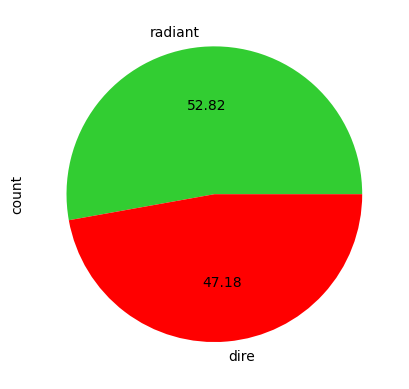

In [96]:
pie = df['winning_team'].value_counts()
pie.plot(kind='pie',colors=['limegreen','r'],autopct='%.2f');

Establish the baseline

In [97]:
baseline = round(max(df.winning_team.value_counts(normalize=True)) *100,2)
print(f'My baseline is {baseline}')

My baseline is 52.82


The win rate is my target vector. and I will now be splitting the data.

In [98]:
target = 'winning_team'

X = df.drop('winning_team', axis=1)
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(X,y,train_size=.8)

Make the Forest Regression Pipeline

In [198]:

mod = make_pipeline(
    OrdinalEncoder(),
    xgb.XGBClassifier(objective='binary:logistic'),
    
)
mod.fit(x_train, LabelEncoder().fit_transform(y_train))



Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['cluster_id', 'game_mode',
                                      'radiant_player_1', 'radiant_player_2',
                                      'radiant_player_3', 'radiant_player_4',
                                      'radiant_player_5', 'dire_player_1',
                                      'dire_player_2', 'dire_player_3',
                                      'dire_player_4', 'dire_player_5'],
                                mapping=[{'col': 'cluster_id',
                                          'data_type': dtype('O'),
                                          'mapping': china              1
us_west            2
southeast_asia     3
sou...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [199]:
print(mod.score(x_train, LabelEncoder().fit_transform(y_train)))
print(mod.score(x_test, LabelEncoder().fit_transform(y_test)))

0.7671796360820751
0.5529855801800058


In [200]:
print('XGBoost Score:')
print(round(mean_absolute_error(LabelEncoder().fit_transform(y_train), mod.predict(x_train)),2))
print(round(mean_absolute_error(LabelEncoder().fit_transform(y_test), mod.predict(x_test)),2))

print('XGBoost Score:')
print(round(mean_squared_error(LabelEncoder().fit_transform(y_train), mod.predict(x_train)),2))
print(round(mean_squared_error(LabelEncoder().fit_transform(y_test), mod.predict(x_test)),2))

print('XGBoost Score:')
print(round(r2_score(LabelEncoder().fit_transform(y_train), mod.predict(x_train)),2))
print(round(r2_score(LabelEncoder().fit_transform(y_test), mod.predict(x_test)),2))


XGBoost Score:
0.23
0.45
XGBoost Score:
0.23
0.45
XGBoost Score:
0.07
-0.79


In [219]:
param_grid = {
    "colsample_bytree": [.3,.5,.8],
    "reg_alpha": [0,.5,1,5],
    "reg_lambda": [0,.5,1,5]
}

estimator = XGBClassifier(
    tree_method="gpu_hist",
    objective= 'binary:logistic',
    nthread=4,
    enable_categorical=True
)


grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    n_jobs=1,
    verbose=0
)
grid_result = grid_search.fit(x_train.astype("category"), LabelEncoder().fit_transform(y_train))

In [220]:
print(grid_result.score(x_train.astype("category"), LabelEncoder().fit_transform(y_train)))
print(grid_result.score(x_test.astype("category"), LabelEncoder().fit_transform(y_test)))

0.7511372435152923
0.5484370463563341


In [222]:
print('XGBoost Score:')
print(round(mean_absolute_error(LabelEncoder().fit_transform(y_train), grid_result.predict(x_train.astype("category"))),2))
print(round(mean_absolute_error(LabelEncoder().fit_transform(y_test), grid_result.predict(x_test.astype("category"))),2))

print('XGBoost Score:')
print(round(mean_squared_error(LabelEncoder().fit_transform(y_train), grid_result.predict(x_train.astype("category"))),2))
print(round(mean_squared_error(LabelEncoder().fit_transform(y_test), grid_result.predict(x_test.astype("category"))),2))

print('XGBoost Score:')
print(round(r2_score(LabelEncoder().fit_transform(y_train), grid_result.predict(x_train.astype("category"))),2))
print(round(r2_score(LabelEncoder().fit_transform(y_test), grid_result.predict(x_test.astype("category"))),2))

XGBoost Score:
0.25
0.45
XGBoost Score:
0.25
0.45
XGBoost Score:
0.0
-0.81


After much deliberation and wasted time on my behalf. I do not believe with how the data was structured that it is possible get the model to predict better. Data that I would liked to have would be position of heroes such as carry or support. I believe this would greatly benefit by giving a much better order to the columns. 

Currently, the order of which hero shows up first is dependent on a first come first serve basis of the heroes api. However, even if the model is nonfunctional, the experience I got cleaning and querying into SQL were invaluable. I also took a deep dive into the xgboost documentation trying to understand how to tune the model. I ended up going with GridSearchCV instead of RandomSearchCV due to knowing I have plenty of time to allow my machine to run every possible hyperparameter it could. Sadly, it returned identical scoring results every permutation I tried. 